# CS81 Adaptive Robotics
## Lab 2a: Simple Logic Neural Networks
### Due next Monday before noon
---

### Introduction

In this notebook you will learn how to use [conx](http://conx.readthedocs.io/en/latest/) to create, train, and test simple neural networks.  The conx library is built on top of [keras](https://keras.io/), which is in turn built on top of [tensorflow](https://www.tensorflow.org/get_started/). 

### Defining a Network

Here are the steps you need to go through to create a neural network in conx.
1. Import the *conx* library.
2. Construct a *Network* object.
3. Add layers to the *Network*, starting with the input and ending with the output. For any non-input layer, specify the size of each layer as well as the activation function to use.  
4. Connect the layers.
5. Compile the network, giving it a *loss* and *optimizer*.  Below we use the Stochastic Gradient Descent (SGD) optimizer with a particular learning rate (lr) and momentum.
6. Verify that the *Network* has the correct structure by creating a summary of the model.

For our first conx network we will be learning logical OR, which will take 2 input values reprenting True/False and outputs True/False. 

In [2]:
import conx as cx

Using Theano backend.
Conx, version 3.6.0


In [5]:
or_net = cx.Network("or")
or_net.add(cx.Layer("input", 2))
or_net.add(cx.Layer("output", 1, activation = "sigmoid"))
or_net.connect()
or_net.compile(loss="mse", optimizer="sgd", lr=0.1, momentum=0.9)
or_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


The number of parameters in a network is based on the size of the layers.  Each layer automatically has an additional node, called the *bias*, which is fully connected to the next layer.  So to determine the number of paramters between any two layers, the formula is: **(size(layer1) + 1) * size(layer2)**.  So for this simple network, we have **(size(input) + 1) * size(output)** = **(2+1) * 1** = **3**.

### Defining a Dataset 

In order to train a neural network you will need to define a dataset.  For small datasets, you can manually add the pairs of input patterns and target patterns one at a time. We will be using two inputs (using 1 to represent True and 0 to represent False) and outputting the OR of the two inputs, where OR(0,0)=0, OR(0,1)=1, OR(1,0)=1, and OR(1,1)=1. Using the **clear** method ensures that you won't add duplicates of the patterns as you are testing within a notebook.

In [7]:
or_net.dataset.clear()
or_net.dataset.append([0,0], [0])
or_net.dataset.append([0,1], [1])
or_net.dataset.append([1,0], [1])
or_net.dataset.append([1,1], [1])
or_net.dataset.summary()

_________________________________________________________________
or Dataset:
Patterns    Shape                 Range                         
inputs      (2,)                  (0.0, 1.0)                    
targets     (1,)                  (0.0, 1.0)                    
Total patterns: 4
   Training patterns: 4
   Testing patterns: 0
_________________________________________________________________


Typically, you would divide the dataset into two subsets, one for training and another for validation. After each pass through the training set, the weights of the network are fixed and the validation set is tested to provide feedback on how well the network is learning.  This works best when the validation set is distinct from the training set. For small datasets, like the case with the OR problem, we don't have enough examples to create two separate datasets. If no validation set is provided, then the training set is also used as the validation set. 

### Training a Network

Use the **reset** method, prior to training, to ensure that the network's parameters are re-initialized to random values. Next the **train** method is called.  The **train** method takes the following paramters.

* **epochs**:
One pass through the entire dataset is called an **epoch** of training.  This indicates the maximum number of epochs of training.
* ** accuracy**:
If the network achieves this percentage correct on the validation set, then training stops early. 
* **tolerance**: 
Defines how close an output has to be to the target to be considered correct.  A tolerance of 0.2 indicates that if the target is 1 and the output is greater than 0.8, it will be correct.  Similary if the target is 0 and the output is less than 0.2, it will be correct.  
* **report_rate**:
Specifies how often (in terms of epochs) the status of network training should be displayed.

This network should train successfully in about 200 epochs.  Notice that training error decreases and accuracy increases over the course of training.  

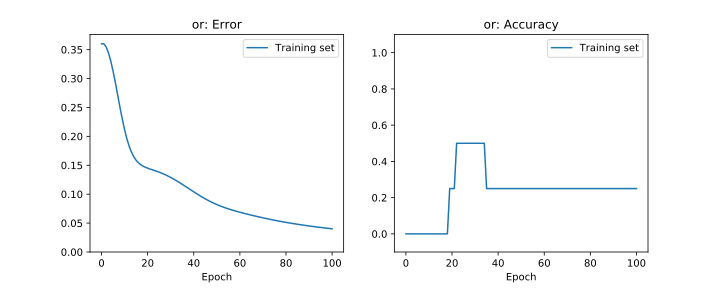

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  100 |   0.04011 |   0.25000 


In [8]:
or_net.reset()
or_net.train(epochs=100, plot=True, report_rate=10)

### Testing a Network

Just as with training, when you test a network you can specify a tolerance level. You should use the same tolerance level when you test as you did when your trained.

In [9]:
or_net.test(show=True)

Testing validation dataset with tolerance 0.1...
# | inputs | targets | outputs | result
---------------------------------------
0 | [[0.00,0.00]] | [[0.00]] | [0.31] | X
1 | [[0.00,1.00]] | [[1.00]] | [0.82] | X
2 | [[1.00,0.00]] | [[1.00]] | [0.83] | X
3 | [[1.00,1.00]] | [[1.00]] | [0.98] | correct
Total count: 4
      correct: 1
      incorrect: 3
Total percentage correct: 0.25


### Inspecting the Weights of a Network

Because the OR network is so small, we can easily look at all of its weights. You can view the weights of network one layer at a time.  The following command displays the weights coming into the **output** layer.

In [10]:
or_net.get_weights("output")

[[[2.408367872238159], [2.2872262001037598]], [-0.788597822189331]]

The last value is the weight from the **bias** node. Remember that the **bias** node has a constant input value of 1.0. Do these weights make sense to you?  How do they work to correctly implement the OR function in the network? 

### Inspecting the Structure of a Network

For very large networks, it is useful to see a visual depiction of the network, showing all of the layers and how they are connected. To do this in **conx**, simply evaluate the **Network** object's name. You can also watch the network propagate patterns one by one through this visualization.  Colors are used to represent the activation level of each node.  The bluer the color, the closer the activation is to 1.0.  The redder the color, the closer the activation is to -1.0.  


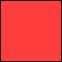
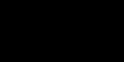

In [12]:
or_net.picture(dynamic=True)

In [14]:
from time import sleep
for pattern in or_net.dataset.inputs:
    or_net.propagate(pattern, update_pictures=True)
    sleep(1.0)

### Saving and Re-Loading a Network

When training very large networks, it is useful to save the final state of the trained weights, and re-load them, rather then re-training from scratch each time.

In [15]:
print("Trained weights", or_net.get_weights("output"))
or_net.save("and_net") # save the network
or_net.reset() # reset the network with new random weights
print("Random weights", or_net.get_weights("output"))
or_net.load("and_net") # load the saved network
print("Restored weights", or_net.get_weights("output"))

Trained weights [[[2.408367872238159], [2.2872262001037598]], [-0.788597822189331]]
Random weights [[[0.5645480751991272], [0.9678440093994141]], [0.0]]
Restored weights [[[2.408367872238159], [2.2872262001037598]], [-0.788597822189331]]


### Create, Train, and Test an AND network

Now that you've seen how to use **conx**, create your own network to solve the logical AND problem, where AND(0,0)=0, AND(0,1)=0, AND(1,0)=0, and AND(1,1)=1. Be sure to inspect the weights after training, and explain how the network has solved the problem. 

In [16]:
# Create the and_net 

In [17]:
# Create the and_net dataset 

In [18]:
# Train the and_net 

In [19]:
# Test the and_net 

In [20]:
# Inspect the and_net weights and explain them

### Solving XOR

The XOR logic problem is harder to solve than the previous two problems.  Recall that XOR(0,0)=0, XOR(0,1)=1, XOR(1,0)=1, and XOR(1,1)=0. It cannot be solved without adding another layer of nodes into the network. Any layer of nodes between the input and output layers is typically called a **hidden** layer.  If you need multiple hidden layers, you must give them unique names. 

In [22]:
xor_net = cx.Network("xor")
xor_net.add(cx.Layer("input", 2),
            cx.Layer("hidden", 2, activation="sigmoid"),
            cx.Layer("output", 1, activation="sigmoid"))
xor_net.connect()
xor_net.compile(loss="mse", optimizer="sgd", lr=0.1, momentum=0.9)
xor_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden (Dense)               (None, 2)                 6         
_________________________________________________________________
output (Dense)               (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Explain why there are 9 parameters in this XOR network.

### Another way to Create a Dataset

Rather than adding the training patterns one at a time as we did previously, you can instead create a list of all of the pairs of input, target patterns as shown below.

In [23]:
data = [
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
    ]
xor_net.dataset.clear()
xor_net.dataset.load(data)
xor_net.dataset.summary()

_________________________________________________________________
xor Dataset:
Patterns    Shape                 Range                         
inputs      (2,)                  (0.0, 1.0)                    
targets     (1,)                  (0.0, 1.0)                    
Total patterns: 4
   Training patterns: 4
   Testing patterns: 0
_________________________________________________________________


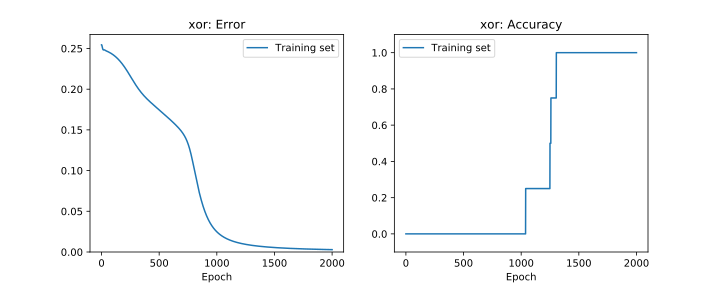

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
# 2000 |   0.00289 |   1.00000 


In [24]:
xor_net.reset()
xor_net.train(epochs=2000, report_rate=100, plot=True)

In [25]:
xor_net.test(show=True)

Testing validation dataset with tolerance 0.1...
# | inputs | targets | outputs | result
---------------------------------------
0 | [[0.00,0.00]] | [[0.00]] | [0.05] | correct
1 | [[0.00,1.00]] | [[1.00]] | [0.94] | correct
2 | [[1.00,0.00]] | [[1.00]] | [0.94] | correct
3 | [[1.00,1.00]] | [[0.00]] | [0.06] | correct
Total count: 4
      correct: 4
      incorrect: 0
Total percentage correct: 1.0


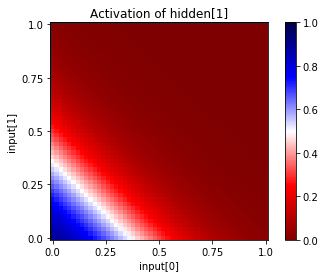

In [26]:
xor_net.plot_activation_map(to_layer="hidden", from_layer="input", to_unit=1, from_units=(0, 1))

### XOR without a hidden layer

Go back up to the cell where **xor_net** was defined, and comment out the line that adds the hidden layer.  Re-train and re-test the network.  How does it do?  

Be sure to reinistate this line after you are done. 

### Inspecting the XOR weights

To inspect all of the XOR weights you need to look at the weights coming into the **hidden** layer, as well as the weights coming into the **output** layer.  Try to make sense of how the network is solving the XOR problem.

In [27]:
xor_net.get_weights("hidden")

[[[3.8168671131134033, -5.82452917098999],
  [3.844735622406006, -6.013904094696045]],
 [-5.944973945617676, 2.136547327041626]]

In [28]:
xor_net.get_weights("output")

[[[-7.853579998016357], [-7.672724723815918]], [3.844650983810425]]

### Use git to add, commit, and push

Be sure to save this notebook before moving on.